In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import cv2
from PIL import Image
from tqdm import tqdm


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [0]:
from pathlib import Path

path = Path("drive/My Drive/wheat")
image_folder = "drive/My Drive/wheat/train"

In [8]:
# read raw train data
train = pd.read_csv(path/"train.csv")
print(train.shape)
train.head()

(147793, 5)


,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [9]:
# read clean wheat data
wheat = pd.read_csv(path/"wheat.csv")
print(wheat.shape)
wheat.head()

(147793, 5)


,image_id,xmin,ymin,xmax,ymax
0,b6ab77fd7.jpg,834.0,222.0,890.0,258.0
1,b6ab77fd7.jpg,226.0,548.0,356.0,606.0
2,b6ab77fd7.jpg,377.0,504.0,451.0,664.0
3,b6ab77fd7.jpg,834.0,95.0,943.0,202.0
4,b6ab77fd7.jpg,26.0,144.0,150.0,261.0


### Train / Valid split

- **usask_1** and **rres_1** as validation set.
- Number of images roughly 20%.

In [10]:
# carve out a validation set from 2 sources
valid_id = train.loc[train.source.isin(["usask_1", "rres_1"])].image_id.unique()
len(valid_id)

632

In [11]:
# number of training examples
train.image_id.nunique() - len(valid_id)

2741

In [0]:
valid_id = [Id+".jpg" for Id in valid_id]  # image_id of validation set

In [13]:
train_wheat = wheat.loc[~wheat.image_id.isin(valid_id)].reset_index(drop=True)
valid_wheat = wheat.loc[wheat.image_id.isin(valid_id)].reset_index(drop=True)
print("train:", train_wheat.shape, "valid:", valid_wheat.shape)

train: (121750, 5) valid: (26043, 5)


In [14]:
train_wheat.head()

,image_id,xmin,ymin,xmax,ymax
0,44c60402e.jpg,830.0,21.0,896.0,78.0
1,44c60402e.jpg,752.0,0.0,804.0,49.0
2,44c60402e.jpg,321.0,0.0,467.0,32.0
3,44c60402e.jpg,363.0,32.0,471.0,97.0
4,44c60402e.jpg,555.0,63.0,612.0,109.0


- What about images without bounding boxes?
- Bboxes normalization?
- Non-max suppression: how do you know it's the same object?
- kmeans of anchor boxes

### Dataset

In [0]:
class WheatDataSet(Dataset):
    def __init__(self, df, folder):  # transform!
        self.df = df
        self.image_ids = df.image_id.unique()
        self.folder = folder
        
    def __len__(self):
        return self.image_ids.shape[0]
    
    def __getitem__(self, idx):
        # get image and transform
        image_id = self.image_ids[idx]
        image = cv2.imread(f"{self.folder}/{image_id}", cv2.IMREAD_COLOR)  # Convert to B G R channels
#         tmp, image[:, :, 0], image[:, :, 2] = image[:, :, 0], image[:, :, 2], tmp  # swap BGR to RGB
#         image[:, :, [2, 1, 0]] = image[:, :, [0, 1, 2]]
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0  # normalize to 0~1
        
        # boxes and area
        records = self.df.loc[self.df.image_id == image_id]  # all records associated with the image
        boxes = records[["xmin", "ymin", "xmax", "ymax"]].values
        area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])  # area of the bounding boxes
        
        # convert everything into tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        area = torch.as_tensor(area, dtype=torch.float32)
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        # compile target to return
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor([idx])
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        # iamge is not a tensor
        return image, target #, image_id
        

In [0]:
train_ds = WheatDataSet(train_wheat, image_folder)
valid_ds = WheatDataSet(valid_wheat, image_folder)

In [0]:
# train_ds[0]

In [18]:
# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = 2  # 1 class (wheat) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [0]:
# reference: https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train
# define loss metric
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0
    
    def send(self, value):
        self.current_total += value
        self.iterations += 1
    
    @property
    def value(self):
        if self.iterations == 0: 
            return 0
        else:
            return self.current_total / self.iterations  # 1.0 *
    
    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [0]:
# customize batch?
def collate_fn(batch):
    return tuple(zip(*batch))  # pack image & target into a tuple

In [0]:
train_dl = DataLoader(train_ds, batch_size=16, collate_fn=collate_fn)  #shuffle=False
valid_dl = DataLoader(valid_ds, batch_size=16, collate_fn=collate_fn)  #num_workers=4, 

In [0]:
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [0]:
# example
images, targets = next(iter(train_dl))
images = [torch.as_tensor(image, dtype=torch.float32).cuda() for image in images]
targets = [{k:v.cuda() for k, v in t.items()} for t in targets]

In [0]:
model

In [108]:
model(images, targets)

RuntimeError: ignored

In [101]:
images[0].permute(2, 0, 1).shape

torch.Size([3, 1024, 1024])

In [0]:
boxes = targets[4]["boxes"].cpu().detach().numpy()
image = images[4].cpu().detach().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


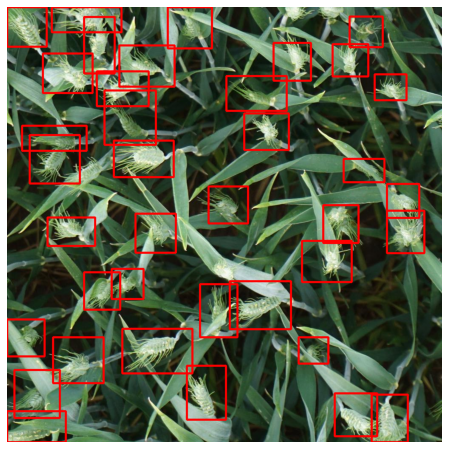

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(image,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (255, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(image)

### Train model

In [0]:
model.cuda()

parameters = filter(lambda p: p.requires_grad, model.parameters())  # [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(parameters, lr=0.005, weight_decay=0.001)

In [0]:
def train_epocs(model, optimizer, train_dl, valid_dl, epochs=10):
    loss_hist = Averager()
    for i in range(epochs):
        model.train()
        loss_hist.reset()
        for images, targets in train_dl:
            images = [torch.as_tensor(image, dtype=torch.float32).cuda() for image in images]
            targets = [{k:v.cuda() for k, v in t.items()} for t in targets]
            
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()
            loss_hist.send(loss_value)

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

        # val_loss, val_acc = val_metrics(model, valid_dl)
        # if i % 5 == 1:
        print("train loss %.3f val loss %.3f and val accuracy %.3f" % (loss_hist.value, val_loss, val_acc))

In [0]:
def val_metrics(model, valid_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    for x, s, y in valid_dl:
        x = x.long().cuda()
        y = y.float().unsqueeze(1).cuda()
        y_hat = model(x, s)
        loss = F.binary_cross_entropy_with_logits(y_hat, y)
        y_pred = y_hat > 0
        correct += (y_pred.float() == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
    return sum_loss/total, correct/total

In [0]:
train_wheat.loc[train_wheat.image_id == "44c60402e.jpg"].shape

(60, 5)

In [0]:
np.array(Image.open("../data/train/44c60402e.jpg"))

array([[[ 11,  28,   9],
        [ 14,  31,  12],
        [ 18,  35,  16],
        ...,
        [ 95, 117,  55],
        [122, 142,  81],
        [126, 146,  85]],

       [[  9,  26,   7],
        [ 11,  28,   9],
        [ 14,  31,  12],
        ...,
        [137, 160,  92],
        [113, 136,  68],
        [ 90, 113,  45]],

       [[  7,  24,   5],
        [  8,  25,   6],
        [ 10,  27,   8],
        ...,
        [157, 185, 108],
        [112, 139,  62],
        [ 77, 104,  27]],

       ...,

       [[ 27,  72,   5],
        [ 56, 101,  34],
        [108, 153,  84],
        ...,
        [ 10,  33,   5],
        [  9,  32,   4],
        [  8,  33,   3]],

       [[  0,  39,   0],
        [ 20,  67,   0],
        [ 81, 126,  57],
        ...,
        [ 12,  35,   6],
        [ 10,  35,   3],
        [ 10,  35,   3]],

       [[  8,  58,   0],
        [ 19,  66,   0],
        [ 78, 125,  55],
        ...,
        [ 11,  35,   3],
        [ 10,  35,   3],
        [ 10,  36,   1]]